In [1]:
import sys
import datetime
import plotly
import plotly.graph_objects as go
import sqlalchemy

from buhtuh.pandasql import BuhTuhDataFrame

# enable these once we visualize sankey charts
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# import pandas as pd

## Get website production data

In [2]:
## get some data, add database and credentials here
engine = sqlalchemy.create_engine('postgresql://objectiv:@localhost:5432/website')

In [3]:
## production website data (from sessionized_data + features)
buh_tuh = BuhTuhDataFrame.from_table(engine=engine, table_name='basic_features', index=['event_id'])

## Set the timeframe

In [4]:
# set the timeframe for analysis
selector = (buh_tuh['moment'] >= datetime.date(2021,6,1)) & (buh_tuh['moment'] < datetime.date(2021,10,2))

# create one sampled df with timeframe applied and one with the full dataset
timeframe_df = buh_tuh[selector]
full_df = buh_tuh

timeframe_df.sort_values({'moment': False}).head()

,session_id,session_hit_number,user_id,moment,cookie_id,event,global_contexts,location_stack,time,events,stack_selection,selected_stack_location,feature_hash,feature,feature_pretty_name
event_id,,,,,,,,,,,,,,,
1b3dcc5f-f18e-437d-bdec-b41ff6317e28,4936,1,b481654c-95f2-471d-aaf0-231bbdd2b787,2021-10-01 10:13:00.095,b481654c-95f2-471d-aaf0-231bbdd2b787,ApplicationLoadedEvent,"[{'_type': 'ApplicationContext', 'id': 'object...","[{'_type': 'WebDocumentContext', 'id': '#docum...",1633083180095,"[AbstractEvent, ApplicationLoadedEvent, NonInt...","(,#document)","[{'_context_type': None, 'id': '#document'}]",d42f522a327a683306856a6d62d15c27,"(,#document)","Pretty(,#document)"
1b74c640-d5e7-42a1-8079-69412c6689fb,4935,2,75e20436-1367-4cbd-aeaf-830ba471a2e8,2021-10-01 09:33:52.571,75e20436-1367-4cbd-aeaf-830ba471a2e8,SectionHiddenEvent,"[{'_type': 'ApplicationContext', 'id': 'object...","[{'_type': 'WebDocumentContext', 'id': '#docum...",1633080832571,"[AbstractEvent, NonInteractiveEvent, SectionHi...","(,#document),(,hamburger-menu)","[{'_context_type': None, 'id': '#document'}, {...",e92418c86d6f0c6835427d70b58f1cfd,"(,#document),(,hamburger-menu)","Pretty(,#document),(,hamburger-menu)"
a45552ef-331f-4f02-a4a9-dfd137d25391,4935,1,75e20436-1367-4cbd-aeaf-830ba471a2e8,2021-10-01 09:33:50.138,75e20436-1367-4cbd-aeaf-830ba471a2e8,SectionVisibleEvent,"[{'_type': 'ApplicationContext', 'id': 'object...","[{'_type': 'WebDocumentContext', 'id': '#docum...",1633080830138,"[AbstractEvent, NonInteractiveEvent, SectionVi...","(,#document),(,hamburger-menu)","[{'_context_type': None, 'id': '#document'}, {...",fb89df4c89d614ffe0cd806e6a92df2f,"(,#document),(,hamburger-menu)","Pretty(,#document),(,hamburger-menu)"
36ee5bfe-673b-457d-a0d8-d17e778198d5,4934,1,75e20436-1367-4cbd-aeaf-830ba471a2e8,2021-10-01 09:33:41.547,75e20436-1367-4cbd-aeaf-830ba471a2e8,ApplicationLoadedEvent,"[{'_type': 'ApplicationContext', 'id': 'object...","[{'_type': 'WebDocumentContext', 'id': '#docum...",1633080821547,"[AbstractEvent, ApplicationLoadedEvent, NonInt...","(,#document)","[{'_context_type': None, 'id': '#document'}]",d42f522a327a683306856a6d62d15c27,"(,#document)","Pretty(,#document)"
61052546-b963-47b6-a6e9-5a0a15bff55e,4933,5,fe2657f1-a08c-4e33-b762-441c2f52855c,2021-10-01 09:18:49.419,fe2657f1-a08c-4e33-b762-441c2f52855c,SectionVisibleEvent,"[{'_type': 'ApplicationContext', 'id': 'object...","[{'_type': 'WebDocumentContext', 'id': '#docum...",1633079929419,"[AbstractEvent, NonInteractiveEvent, SectionVi...","(,#document),(,footer)","[{'_context_type': None, 'id': '#document'}, {...",4eb9370797053f1879ceb4dcf2c1b9eb,"(,#document),(,footer)","Pretty(,#document),(,footer)"


## Set the time aggregation 

In [5]:
# choose for which level of time aggregation the rest of the analysis will run
# supports all Postgres datetime template patterns:
# https://www.postgresql.org/docs/9.1/functions-formatting.html#FUNCTIONS-FORMATTING-DATETIME-TABLE

#agg_level = 'YYYYIW'
agg_level = 'YYYYMMDD'

def time_aggr(bt, format, aggr):
    bt[format.lower()] = bt['moment'].format(format)
    group = bt.groupby([format.lower()])
    return group[list(aggr.keys())].aggregate(aggr)

## User & session totals

In [6]:
# calculate total users & sessions, we can resuse these later
total_users = timeframe_df.groupby()['user_id'].nunique()
total_sessions = timeframe_df.groupby()['session_id'].nunique()

## Users

In [7]:
# calculate unique users 
users = time_aggr(timeframe_df, agg_level, {'user_id':'nunique'})

users.sort_values({agg_level.lower():False}).head()

,user_id_nunique
yyyymmdd,
20211001,14
20210930,2382
20210929,382
20210928,67
20210927,13


<AxesSubplot:xlabel='yyyymmdd'>

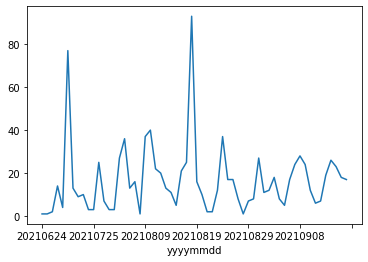

In [21]:
# visualize users
users['user_id_nunique'].sort_values({agg_level.lower():True}).head(60).plot()

## Sessions

In [22]:
# calculate unique sessions
sessions = time_aggr(timeframe_df, agg_level, {'session_id':'nunique'})

sessions.sort_values({agg_level.lower():False}).head()

,session_id_nunique
yyyymmdd,
20210928,8
20210927,20
20210926,14
20210925,16
20210924,50


<AxesSubplot:xlabel='yyyymmdd'>

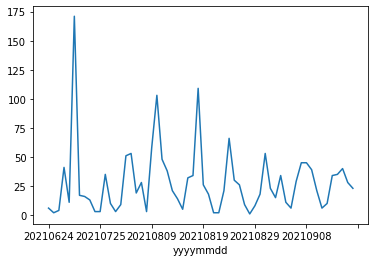

In [23]:
# visualize sessions
sessions['session_id_nunique'].sort_values({agg_level.lower():True}).head(60).plot()

## Sessions per user

In [24]:
# merge users and sessions
users_sessions = sessions.merge(users)

# calculate average sessions per user
users_sessions['sessions_per_user_avg'] = users_sessions['session_id_nunique'] / users_sessions['user_id_nunique']

# clean-up columns
del(users_sessions['session_id_nunique', 'user_id_nunique'])

users_sessions.sort_values({agg_level.lower():False}).head()

,sessions_per_user_avg
yyyymmdd,
20210928,1.142857
20210927,1.538462
20210926,1.272727
20210925,2.000000
20210924,1.612903


<AxesSubplot:xlabel='yyyymmdd'>

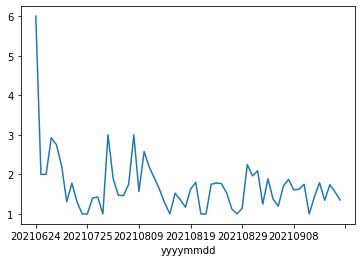

In [25]:
# visualize average sessions per user
users_sessions['sessions_per_user_avg'].sort_values({agg_level.lower():True}).head(60).plot()

## New users

In [26]:
# define first seen per user, based on full dataset
user_first_seen = full_df.groupby(['user_id'])['moment'].min()
user_first_seen[agg_level.lower()] = user_first_seen['moment_min'].format(agg_level)

# calculate new users for each timeframe
new_users = user_first_seen.groupby(agg_level.lower())['user_id'].nunique()

# merge with total users, to calculate ratio and limit to timerange
new_total_users = users.merge(new_users)

# rename and clean-up columns
new_total_users['total_users'] = new_total_users['user_id_nunique_left']
new_total_users['new_users'] = new_total_users['user_id_nunique_right']
del(new_total_users['user_id_nunique_left','user_id_nunique_right'])

# calculate new & returning user share
new_total_users['new_user_share'] = new_total_users['new_users'] / new_total_users['total_users']
new_total_users['returning_user_share'] = (new_total_users['total_users'] - new_total_users['new_users']) / new_total_users['total_users']

new_total_users.sort_values({agg_level.lower():False}).head()

,total_users,new_users,new_user_share,returning_user_share
yyyymmdd,,,,
20210928,7,6,0.857143,0.142857
20210927,13,7,0.538462,0.461538
20210926,11,10,0.909091,0.090909
20210925,8,6,0.750000,0.250000
20210924,31,27,0.870968,0.129032


<AxesSubplot:xlabel='yyyymmdd'>

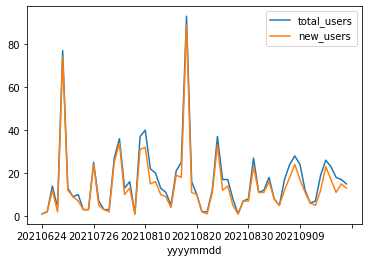

In [27]:
# visualize new users
new_total_users['new_users', 'total_users'].sort_values({agg_level.lower():True}).head(60).plot()

<AxesSubplot:xlabel='yyyymmdd'>

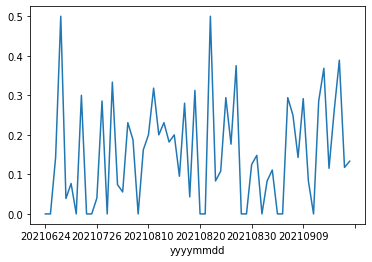

In [28]:
# visualize returning users
new_total_users['returning_user_share'].sort_values({agg_level.lower():True}).head(60).plot()

## Frequency

In [29]:
# number of total sessions per user
total_sessions_user = timeframe_df.groupby(['user_id'])['session_id'].nunique()

# calculate frequency
frequency = total_sessions_user.groupby(['session_id_nunique'])['user_id'].nunique()

# add total users and calculate share per number of sessions
frequency['share_of_users'] = frequency['user_id_nunique'] / total_users['user_id_nunique'][1]

frequency.sort_values({'session_id_nunique':True}).head()

,user_id_nunique,share_of_users
session_id_nunique,,
1,749,0.758865
2,115,0.116515
3,53,0.053698
4,27,0.027356
5,14,0.014184


<AxesSubplot:xlabel='session_id_nunique'>

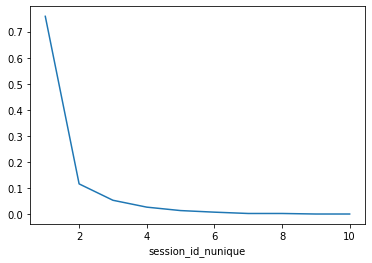

In [30]:
# visualize frequency
frequency['share_of_users'].sort_values({'session_id_nunique':True}).head(10).plot()

## Events

In [31]:
# number of total user per feature
# users_per_event = timeframe_df.groupby(['feature'])['user_id'].nunique()

# users_per_event.sort_values({'user_id_nunique':False}).head()

events_users = timeframe_df['moment', 'feature', 'user_id']
events_users[agg_level.lower()] = events_users['moment'].format(agg_level)

# calculate hits per session
users_per_event = events_users.groupby([agg_level.lower(), 'feature'])['user_id'].nunique()

users_per_event.sort_values({agg_level.lower():False, 'user_id_nunique':False}).head(20)
# TODO: 
# 1) add feature aggregation magic from Bach here, so we make the features show-off what we can do much more 
# 2) add location stack, showing the power of this very soon in the demo's

user_id_nunique
yyyymmdd feature                                                            
20210928 (WebDocumentContext,#document)                                    7
20210927 (WebDocumentContext,#document)                                   13
         (WebDocumentContext,#document),(SectionContext,...                2
         (WebDocumentContext,#document),(LinkContext,logo)                 1
         (WebDocumentContext,#document),(InputContext,ke...                1
         (WebDocumentContext,#document),(SectionContext,...                1
20210926 (WebDocumentContext,#document)                                   11
         (WebDocumentContext,#document),(SectionContext,...                1
         (WebDocumentContext,#document),(SectionContext,...                1
20210925 (WebDocumentContext,#document)                                    8
         (WebDocumentContext,#document),(OverlayContext,...                1
20210924 (WebDocumentContext,#document)                                   31
         (WebDocumentContext,#document),(SectionContext,...                3
         (WebDocumentContext,#document),(SectionContext,...                2
         (WebDocumentContext,#document),(InputContext,ke...                2
         (WebDocumentContext,#document),(LinkContext,logo)                 1
         (WebDocumentContext,#document),(OverlayContext,...                1
         (WebDocumentContext,#document),(SectionContext,...                1
20210923 (WebDocumentContext,#document)                                   26
         (WebDocumentContext,#document),(SectionContext,...                5

## Conversion

In [38]:
# TODO: 
# We can do much better here once we integrate feature selection & aggregation

# NOTE: WE NEED TO UPDATE THIS ONCE THE FIRST NEW EVENT FORMAT DATA COMES IN FOR A CONVERSION
# set the goal event that you define as conversion, using our subcribe-to-mailing
conv_selector = (timeframe_df['feature'] == '(WebDocumentContext,#document),(InputContext,keep-me-posted-input),(ButtonContext,subscribe)')

# create df with only conversion events
conversions_df = timeframe_df[conv_selector]

# calculate conversions, now per user, but can easily be aggregated to session_id instead
conversions = time_aggr(conversions_df, agg_level, {'user_id':'nunique'})

# merge with users, but can easily be done with sessions instead
conversion_rate = conversions.merge(users)

# clean-up and rename columns
conversion_rate['converting_users'] = conversion_rate['user_id_nunique_left']
conversion_rate['total_users'] = conversion_rate['user_id_nunique_right']
del(conversion_rate['user_id_nunique_left','user_id_nunique_right'])

# calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['converting_users'] / conversion_rate['total_users']

conversion_rate.sort_values({agg_level.lower():False}).head(30)

,converting_users,total_users,conversion_rate
yyyymmdd,,,
20210927,1,13,0.076923
20210924,2,31,0.064516
20210923,2,26,0.076923
20210919,1,10,0.100000
20210907,4,24,0.166667
20210906,1,17,0.058824
20210905,1,5,0.200000
20210831,3,27,0.111111
20210825,1,17,0.058824


<AxesSubplot:xlabel='yyyymmdd'>

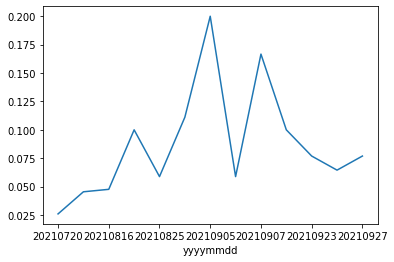

In [33]:
# visualize conversion rate
conversion_rate['conversion_rate'].sort_values({agg_level.lower():True}).head(60).plot()

## Bounce rate

In [34]:
# GA: "Bounce rate is single-page sessions divided by all sessions, or the percentage of all sessions on your site in which users viewed only a single page and triggered only a single request to the Analytics server."
# NOTE: we need to limit this to page or screen views, instead of all events. Do this once we have integration feature selection.

# gather sessions, hits per timeframe
hits_sessions = timeframe_df['moment', 'session_id', 'session_hit_number']
hits_sessions[agg_level.lower()] = hits_sessions['moment'].format(agg_level)

# calculate hits per session
hits_per_session = hits_sessions.groupby([agg_level.lower(), 'session_id'])['session_hit_number'].nunique()

# select sessions with only one hit
hit_selector = (hits_per_session['session_hit_number_nunique'] == 1)
single_hit_sessions = hits_per_session[hit_selector].to_frame()

# count these single hit sessions per timeframe
bounced_sessions = single_hit_sessions.groupby([agg_level.lower()])['session_id'].nunique()

# merge with total sessions and calculate bounce rate
bounce_rate = bounced_sessions.merge(sessions)
bounce_rate['bounce_rate'] = bounce_rate['session_id_nunique_left'] / bounce_rate['session_id_nunique_right']
del(bounce_rate['session_id_nunique_left', 'session_id_nunique_right'])

bounce_rate.sort_values({agg_level.lower():False}).head()

,bounce_rate
yyyymmdd,
20210928,0.875
20210927,0.700
20210926,1.000
20210925,0.875
20210924,0.960


<AxesSubplot:xlabel='yyyymmdd'>

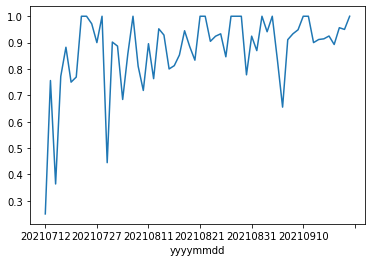

In [35]:
# visualize bounce rate
bounce_rate['bounce_rate'].sort_values({agg_level.lower():True}).head(60).plot()

## Session duration

In [37]:
# calculate duration of each session
session_duration = timeframe_df.groupby(['session_id']).aggregate(['moment','moment'],['min','max'])
session_duration['session_duration'] = session_duration['moment_max'] - session_duration['moment_min']

# check which sessions have duration of zero
session_duration['session_duration_zero'] = session_duration['session_duration'] == '0'

# adding time aggregation, so we can group on this
session_duration[agg_level.lower()] = session_duration['moment_min'].format(agg_level)

# calculate average session duration
avg_session_duration = session_duration.groupby([agg_level.lower(), 'session_duration_zero'])['session_duration'].average()

# count the number of sessions with duration zero or more
session_counts = session_duration.groupby([agg_level.lower(), 'session_duration_zero'])['session_id'].count()

# merge avg session duration and counts
avg_duration_counts = avg_session_duration.merge(session_counts, [(agg_level.lower()),('session_duration_zero')])

# merge with total sessions and calculate share
duration_breakdown = avg_duration_counts.merge(sessions, [agg_level.lower()])
duration_breakdown['share_of_sessions'] = duration_breakdown['session_id_count'] / duration_breakdown['session_id_nunique']
del(duration_breakdown['session_id_nunique'])

duration_breakdown.sort_values({agg_level.lower():False}).head(6)

session_duration_average  session_id_count  \
yyyymmdd session_duration_zero                                              
20210928 True                           0 days 00:00:00                 7   
         False                   0 days 00:00:00.006000                 1   
20210927 False                   0 days 00:00:01.812667                 6   
         True                           0 days 00:00:00                14   
20210926 True                           0 days 00:00:00                14   
20210925 True                           0 days 00:00:00                14   

                                share_of_sessions  
yyyymmdd session_duration_zero                     
20210928 True                               0.875  
         False                              0.125  
20210927 False                              0.300  
         True                               0.700  
20210926 True                               1.000  
20210925 True                               0.875

# TODO

In [ ]:
# below parts first require some next steps in dub_buh_tuh

## Conversion funnel

In [ ]:
# TODO
# Self-merge is giving not the ouput we expect. 
# Without that, we can not create a sankey that looks like a familiar funnel. 
# See example here https://gitlab.com/newrelity/objectiv-taxonomy-prototypes/-/blob/web-analytics/data-science/issue_example_self_merge.ipynb

# showing the sequence of events for converting users

# resuse the df with only conversion events, select the users and their conversion moment
converting_users = conversions_df['user_id', 'moment']

# for now, we focus on the first conversion event. Later it is nice to also make it possible to see events between first and 2nd conversion, and so on.
converting_users = converting_users.groupby(['user_id'])['moment'].min()
converting_users['first_conversion_moment'] = converting_users['moment_min']
del(converting_users['moment_min'])

# merge with the df that has all user events in the timeframe
converting_users_events = timeframe_df.merge(converting_users, [('user_id', 'user_id')])

# select all events that converting users had up to their first conversion moment
event_selector = (converting_users_events['moment'] <= converting_users_events['first_conversion_moment'])
pre_conversion_events = converting_users_events[event_selector]

# create pairs of from-to events based on session hit number
event_sequence = pre_conversion_events['session_id', 'session_hit_number', 'feature']

event_pairs = event_sequence.merge(event_sequence, [('session_id')])

event_pairs.head(50)


In [ ]:
df_sank = pd.read_csv('buh.csv')

In [ ]:
categories = set(df_sank['source']).union(set(df_sank['target']))
df_sank['source'] = pd.Categorical(df_sank['source'], categories=categories)
df_sank['target'] = pd.Categorical(df_sank['target'], categories=categories)

text_in_title = str('title')
node = dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=df_sank.source.cat.categories,
      color='blue'
    )
link = pd.concat([df_sank[['source', 'target']].apply(lambda x: x.cat.codes), df_sank['value']], axis=1).to_dict('list')
fig = go.Figure(go.Sankey(arrangement="fixed", link=link, node=node), {'clickmode': 'event+select'})
fig.update_layout(title_text=text_in_title, font_size=10)

## User timeline

In [ ]:
# show the timeline of an indivual user's events
# NOTE: we can make this better with feature selection & aggregation

# select the spefic user we want to replay
user_id_selector = (buh_tuh['user_id'] == '320db8ee-847c-424b-8291-c65d021575aa')

# create df with only this user's events
# NOTE: timeframe_df['user_id_selector'] breaks: "# We only support first level boolean indices for now", so doing on full df for now
selected_user_df = buh_tuh[user_id_selector]

# left join conversions df, so we can check if the user converted
user_timeline = selected_user_df.merge(conversions_df,how='left')

# rename and clean-up columns
user_timeline['moment'] = user_timeline['moment_left'] 
user_timeline['feature'] = user_timeline['feature_left']
user_timeline['conversion_feature'] = user_timeline['feature_right']

# show relevant columns
user_timeline['moment','feature','conversion_feature'].sort_values({'moment':True}).head()

## Retention cohorts

In [ ]:
# TODO: 
# continue on this when we have datetime intervals, so we can calculate start & end moments of cohorts.

# get the time aggregations where there are users
timeframes = users
timeframes = timeframes.head(100).reset_index()

# cleanup columns we don't need
del(timeframes['user_id_nunique'])
del(timeframes['share_of_total'])

# reset index and use that as cohort numbering
timeframes2 = timeframes.rename_axis('cohort_nr').reset_index()
timeframes2.head()

## Events flow

In [ ]:
# events per session hit number
events_per_hit_number = buh_tuh[selector].groupby(['session_hit_number', 'feature'])['session_id'].nunique()

events_per_hit_number.sort_values({'session_hit_number':True}).head()

## Recency

In [ ]:
# TODO: pick this up once we have window functions

# "the number of days between the close of one session and the opening of another"
test = timeframe_df.groupby(['user_id', 'session_id']).aggregate(['moment','moment'],['min','max'])

test.head()


## Traffic source

In [ ]:
# TODO
# For Traffic Source, Geo and Device metrics, we would need to get source/geo/device data from GlobalContext in a easy way.
# We can then also blend it in all metrics above as slicing option.

## Geo 

## Devices

## BI example - Metabase

In [ ]:
# users
users.head(30).to_sql('metabase_users', con=engine, if_exists='replace')

# new users
new_total_users.head(30).to_sql('metabase_new_total_users', con=engine, if_exists='replace')

# events
users_per_event.head(30).to_sql('metabase_users_per_event', con=engine, if_exists='replace')

# conversion
conversion_rate.head(30).to_sql('metabase_conversion_rate', con=engine, if_exists='replace')